In [152]:
import numpy as np
import pandas as pd
from q_value_calc_crosslinks import readAndProcessIdXML, calcQ, FDR_summary
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import re

Choose input file

In [153]:
#input_file = "../data/crosslink_data/M_Raabe_A_Wulf_220421_270421_Expl3_Ecoli_XL_UV_S30_LB_bRPfrac_11.idXML" # rank 0
#input_file_perc = "../data/crosslink_data/M_Raabe_A_Wulf_220421_270421_Expl3_Ecoli_XL_UV_S30_LB_bRPfrac_11_perc.idXML" # rank 0 - 7
#input_file = "../data/crosslink_data/M_Raabe_A_Wulf_220421_290421_Expl3_Ecoli_XL_DEB_S30_LB_bRPfrac_12.idXML" # rank 0
#input_file_perc = "../data/crosslink_data/M_Raabe_A_Wulf_220421_290421_Expl3_Ecoli_XL_DEB_S30_LB_bRPfrac_12_perc.idXML" # rank 0 - 7
#input_file = "../data/crosslink_data/MRaabe_LW_091221_171221_Expl2_XL_Ecoli_NM_S30_bRP_rep1_11.idXML" # rank 0
#input_file_perc = "../data/crosslink_data/MRaabe_LW_091221_171221_Expl2_XL_Ecoli_NM_S30_bRP_rep1_11_perc.idXML" # rank 0 - 7
input_file_perc = "../data/crosslink_data/AChernev_080219_HeLa_RNA_UV_opti_.idXML"
input_file = "../data/crosslink_data/AChernev_080219_HeLa_RNA_UV.idXML"


Read and filter data to relevant columns

In [154]:
features = ['Score','peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                'NuXL:mass_error_p', 'NuXL:tag_unshifted' ,
                'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                'variable_modifications']
scaling = ['Score', 'peplen', 'NuXL:isXL', 'NuXL:modds', 'NuXL:pl_modds', 
                'NuXL:mass_error_p', 'NuXL:tag_unshifted' ,
                'NuXL:tag_shifted', 'missed_cleavages', 'NuXL:ladder_score',
                'variable_modifications']

# read data
original_df = readAndProcessIdXML(input_file)
q_vals_before = calcQ(original_df)
perc_df = readAndProcessIdXML(input_file_perc)
#perc_df = perc_df.loc[perc_df['rank'] == 0,:]
q_vals_perc = calcQ(perc_df)

# filter data and sort according to score
df = original_df.filter(np.concatenate([features,['rank', 'Label']]))
df = df.sort_values('Score',ascending=False)

c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)
c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Determine minority class of datapoints

In [155]:
# determine minority class 
minority_class = min({df.loc[df['NuXL:isXL'] == 0].size, df.loc[df['NuXL:isXL'] == 1].size})
class_threshold = 500
if (minority_class > class_threshold): minority_class = class_threshold
# define training data (peptides with top and bottom scores of each class with rank 0)
pep_top = df.loc[(df['NuXL:isXL'] == 0) & (df['rank'] == 0)][:int(minority_class/2)]
pep_bottom = df.loc[(df['NuXL:isXL'] == 0) & (df['rank'] == 0)][-int(minority_class/2):]
XL_top = df.loc[(df['NuXL:isXL'] == 1) & (df['rank'] == 0)][:int(minority_class/2)]
XL_bottom = df.loc[(df['NuXL:isXL'] == 1) & (df['rank'] == 0)][-int(minority_class/2):]
train_idx = np.concatenate([pep_top.index, pep_bottom.index, XL_top.index, XL_bottom.index])

In [156]:
labels = np.empty(len(df))
labels[pep_bottom.index] = 0
labels[XL_bottom.index] = 0
labels[pep_top.index] = 1
labels[XL_top.index] = 1

In [157]:
# min-max feature scaling to 0-1
scaler = MinMaxScaler()
scaler.fit(df.loc[train_idx,scaling])
df[scaling] = scaler.transform(df[scaling])

In [ ]:
if (minority_class > 10):
    # grid search on C value
    param_grid = {
        'C': np.power(float(2), [-5,-1,1,5,7,11,15]),
        #'epsilon': np.power(float(2), [-15,-9,-6,-3.32192809489,0,3.32192809489,6,9,15])
    }
    no_split = 5
    kf = KFold(n_splits=no_split, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        SVC(kernel='linear', probability=True),
        param_grid,
        cv=kf,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    # fit model to train data
    grid_search.fit(df.loc[train_idx, features], labels[train_idx])
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")
    
    # run model on all data points
    probabilities = grid_search.predict_proba(df.loc[:, features])
    print(f"Predicting class probabilities: {probabilities}")
    
    # features of best model
    print(f"Feature weights: {grid_search.best_estimator_.coef_}")
    feature_scaling = pd.DataFrame(np.vstack([scaler.data_min_,scaler.data_max_]).T, columns = ["min", "max"], index=scaling)
    print(f"Feature scaling:{feature_scaling}")
    
    # set probabilites as new score
    #new_scores = pd.DataFrame(np.vstack([probabilities[:,1], df.loc[:, 'Label'], df.loc[:, 'NuXL:isXL']]).T, columns = ['Score', 'Label', 'NuXL:isXL'], index = df.index)
    # q value computation for new scores
    new_scores = original_df.copy()
    new_scores['Score'] = probabilities[:,1]
    q_vals_after = calcQ(new_scores)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best parameters: {'C': 0.03125}
Best cross-validation accuracy: 1.000
Predicting class probabilities: [[1.35807814e-12 1.00000000e+00]
 [3.21557136e-10 1.00000000e+00]
 [2.38293991e-10 1.00000000e+00]
 ...
 [9.99436047e-01 5.63953450e-04]
 [9.98356795e-01 1.64320540e-03]
 [9.99452345e-01 5.47655468e-04]]
Feature weights: [[ 0.93843825  0.14387685 -0.10849388  0.64818263  0.39970413  0.25234385
   0.64027694  0.24655352 -0.13636433  1.40904718 -0.21679766]]
Feature scaling:                             min         max
Score                   1.627570  165.613602
peplen                  8.000000   78.000000
NuXL:isXL               0.000000    1.000000
NuXL:modds              1.420493  165.613602
NuXL:pl_modds           0.000000  118.746941
NuXL:mass_error_p       0.123561    1.000000
NuXL:tag_unshifted      1.000000   26.000000
NuXL:tag_shifted        0.000000   17.000000
missed_cleavages        0.000000    2.000000
NuXL:ladder_

c:\Users\mail\Research-Project\src\q_value_calc_crosslinks.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[labelColName].replace(to_replace=-1, value=0, inplace=True)


In [159]:
def get_target_id(
    scores: pd.DataFrame,                   # pd.DataFrame: Input data containing PSMs and q-values
    isXLColName: str = "NuXL:isXL",           # str: Column name indicating if the peptide is crosslinked
    label_col: str = "Label",              # str: Column name for the label, indicating target (1) or decoy
    q_val_col: str = "class-specific_q-val",
    max_qvalue: float = 0.1
):
    scores.sort_values("Score",ascending=False,inplace=True)
    # Initialize a dictionary to store counts of PSMs below each q-value threshold
    result = []
    for XL in [0,1]:
        XL_summary_q_val_count = []
        
        # Filter for crosslinked (XL) PSMs
        XL_psms_q_df = scores[scores[isXLColName] == XL]
        XL_psms_q_df.sort_values(['class-specific_q-val', 'Score'], ascending=[True, False], inplace=True)

        XL_q_value_thresholds = XL_psms_q_df[q_val_col]

        # Further filter to keep only target PSMs (label == 1)
        XL_psms_q_df = XL_psms_q_df[XL_psms_q_df[label_col] == 1]
        # Count the number of PSMs below each q-value threshold
        for qvalue in XL_q_value_thresholds:
            # Count XL PSMs below the class-specific q-value threshold
            XL_summary_q_val_count.append(sum(j < min(qvalue, max_qvalue) for j in XL_psms_q_df[q_val_col]))
        result.append(XL_q_value_thresholds)
        result.append(XL_summary_q_val_count)

    return result

pep_q_value_thresholds_after, pep_target_id_after, XL_q_value_thresholds_after, XL_target_id_after = get_target_id(q_vals_after)
pep_q_value_thresholds_before, pep_target_id_before, XL_q_value_thresholds_before, XL_target_id_before  = get_target_id(q_vals_before)
pep_q_value_thresholds_perc, pep_target_id_perc, XL_q_value_thresholds_perc, XL_target_id_perc = get_target_id(q_vals_perc)

C:\Users\mail\AppData\Local\Temp\ipykernel_24008\3531029102.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XL_psms_q_df.sort_values(['class-specific_q-val', 'Score'], ascending=[True, False], inplace=True)


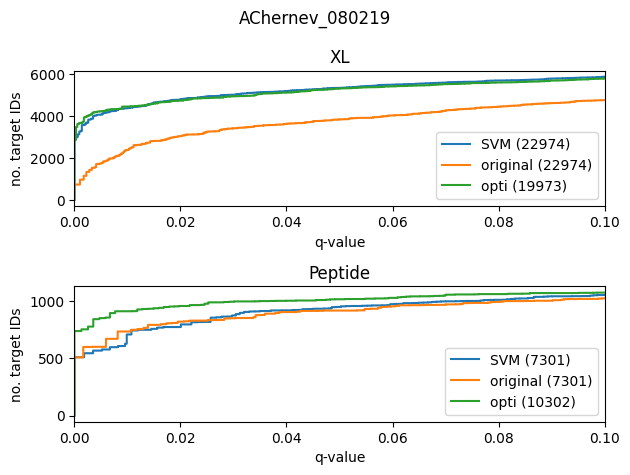

In [160]:
fig, axs = plt.subplots(2)
axs[0].step(XL_q_value_thresholds_after,XL_target_id_after, label=f"SVM ({len(XL_q_value_thresholds_after)})" )
axs[1].step(pep_q_value_thresholds_after,pep_target_id_after, label=f"SVM ({len(pep_q_value_thresholds_after)})")
axs[0].step(XL_q_value_thresholds_before,XL_target_id_before, label=f"original ({len(XL_q_value_thresholds_before)})" )
axs[1].step(pep_q_value_thresholds_before,pep_target_id_before, label = f"original ({len(pep_q_value_thresholds_before)})")
axs[0].step(XL_q_value_thresholds_perc,XL_target_id_perc, label=f"opti ({len(XL_q_value_thresholds_perc)})")
axs[1].step(pep_q_value_thresholds_perc,pep_target_id_perc, label=f"opti ({len(pep_q_value_thresholds_perc)})")
axs[0].set_xlim(0,0.1)
axs[1].set_xlim(0,0.1)
axs[0].set_title("XL")
axs[1].set_title("Peptide")
axs[0].set_xlabel("q-value")
axs[1].set_xlabel("q-value")
axs[0].set_ylabel("no. target IDs")
axs[1].set_ylabel("no. target IDs")
axs[0].legend()
axs[1].legend()
str_title = re.search("_data/.*_(Expl|HeLa)", input_file).group()[6:-5]
fig.suptitle(str_title)
fig.tight_layout()
plt.show()

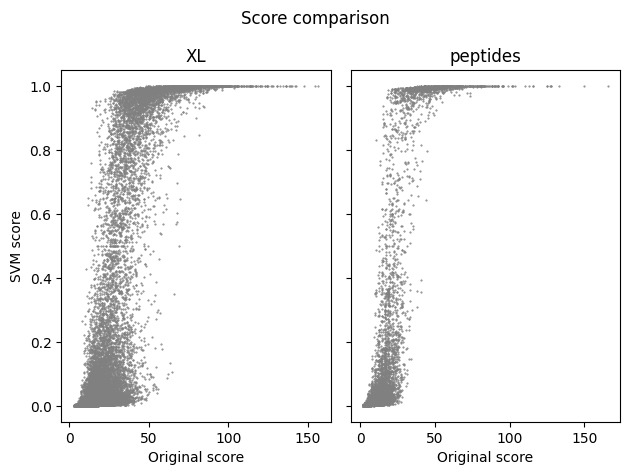

In [161]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1,2, sharey=True)
q_val_threshold = 0
q_vals_after.sort_index(inplace=True)
q_vals_before.sort_index(inplace=True)
idx_XL = q_vals_after[(q_vals_after['class-specific_q-val'] < q_val_threshold) & (q_vals_after['NuXL:isXL'] == 1)].index 
idx_pep = q_vals_after[(q_vals_after['class-specific_q-val'] < q_val_threshold) & (q_vals_after['NuXL:isXL'] == 0)].index 
idx_XL_2 = q_vals_after[(q_vals_after['class-specific_q-val'] >= q_val_threshold) & (q_vals_after['NuXL:isXL'] == 1)].index 
idx_pep_2 = q_vals_after[(q_vals_after['class-specific_q-val'] >= q_val_threshold) & (q_vals_after['NuXL:isXL'] == 0)].index 
axs[0].scatter(q_vals_before.loc[idx_XL_2, 'Score'], q_vals_after.loc[idx_XL_2, 'Score'], marker=".", c='gray',s=1, label='XL')
axs[1].scatter(q_vals_before.loc[idx_pep_2, 'Score'], q_vals_after.loc[idx_pep_2, 'Score'], marker=".", c='gray', s=1, label='peptide')
#sc1 = axs[0].scatter(q_vals_before.loc[idx_XL, 'Score'], q_vals_after.loc[idx_XL, 'Score'], marker=".", c=q_vals_after.loc[idx_XL,'class-specific_q-val'],s=1, label='XL')
#sc2 = axs[1].scatter(q_vals_before.loc[idx_pep, 'Score'], q_vals_after.loc[idx_pep, 'Score'], marker=".", c=q_vals_after.loc[idx_pep,'class-specific_q-val'], s=1, label='peptide')
axs[0].set_xlabel('Original score')
axs[1].set_xlabel('Original score')
axs[0].set_ylabel('SVM score')
axs[0].set_title('XL')
axs[1].set_title('peptides')
#divider = make_axes_locatable(axs[0])
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(sc1, cax=cax, orientation='vertical')
#divider = make_axes_locatable(axs[1])
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(sc2, cax=cax, orientation='vertical', label='class-specific q-value')
fig.suptitle("Score comparison")
plt.tight_layout()
plt.show()

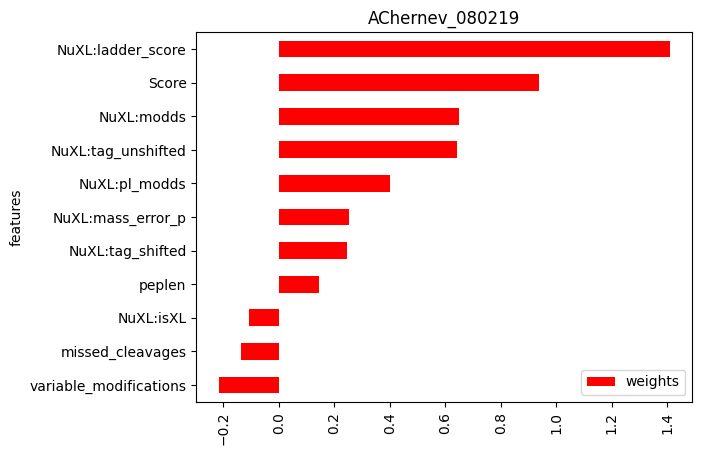

In [162]:
feature_weights=pd.DataFrame({'features':features,'weights':grid_search.best_estimator_.coef_[0]})
feature_weights.sort_values('weights',inplace=True)
feature_weights.plot(kind='barh',y='weights',x='features',color='r')
plt.xticks(rotation=90)
plt.title(str_title)
plt.show()

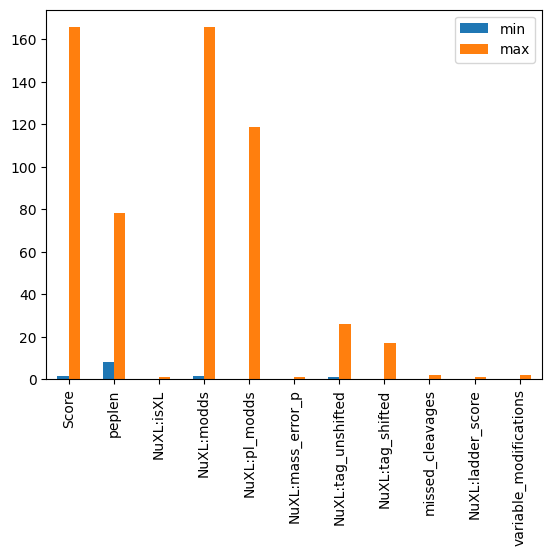

In [163]:
feature_scaling.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

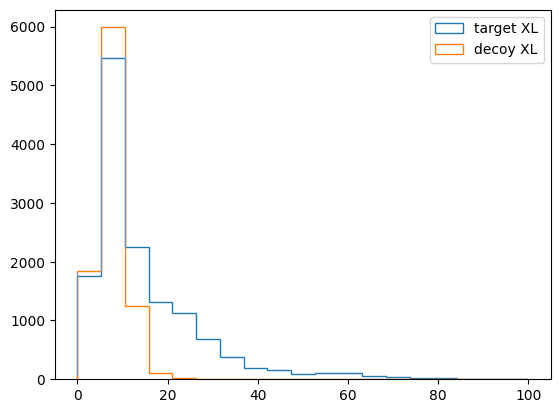

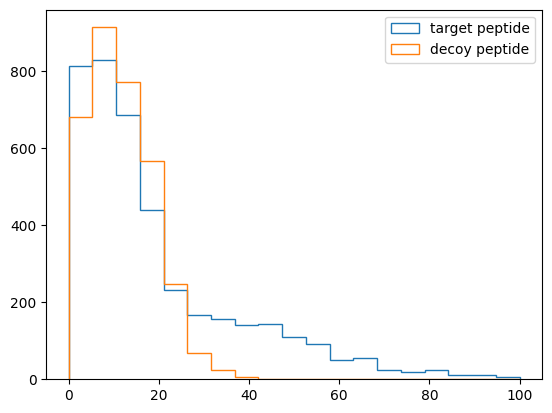

In [164]:
feature = 'NuXL:modds'
bins = np.linspace(0, 100, 20)
plt.hist(q_vals_after.loc[(q_vals_after['Label']==1) & (q_vals_after['NuXL:isXL']==1), feature], histtype="step", label = "target XL",bins=bins)
plt.hist(q_vals_after.loc[(q_vals_after['Label']==0) & (q_vals_after['NuXL:isXL']==1), feature], histtype="step", label = "decoy XL",bins=bins)
plt.legend()
plt.show()
plt.hist(q_vals_after.loc[(q_vals_after['Label']==1) & (q_vals_after['NuXL:isXL']==0), feature], histtype="step", label = "target peptide",bins=bins)
plt.hist(q_vals_after.loc[(q_vals_after['Label']==0) & (q_vals_after['NuXL:isXL']==0), feature], histtype="step", label = "decoy peptide",bins=bins)
plt.legend()
plt.show()

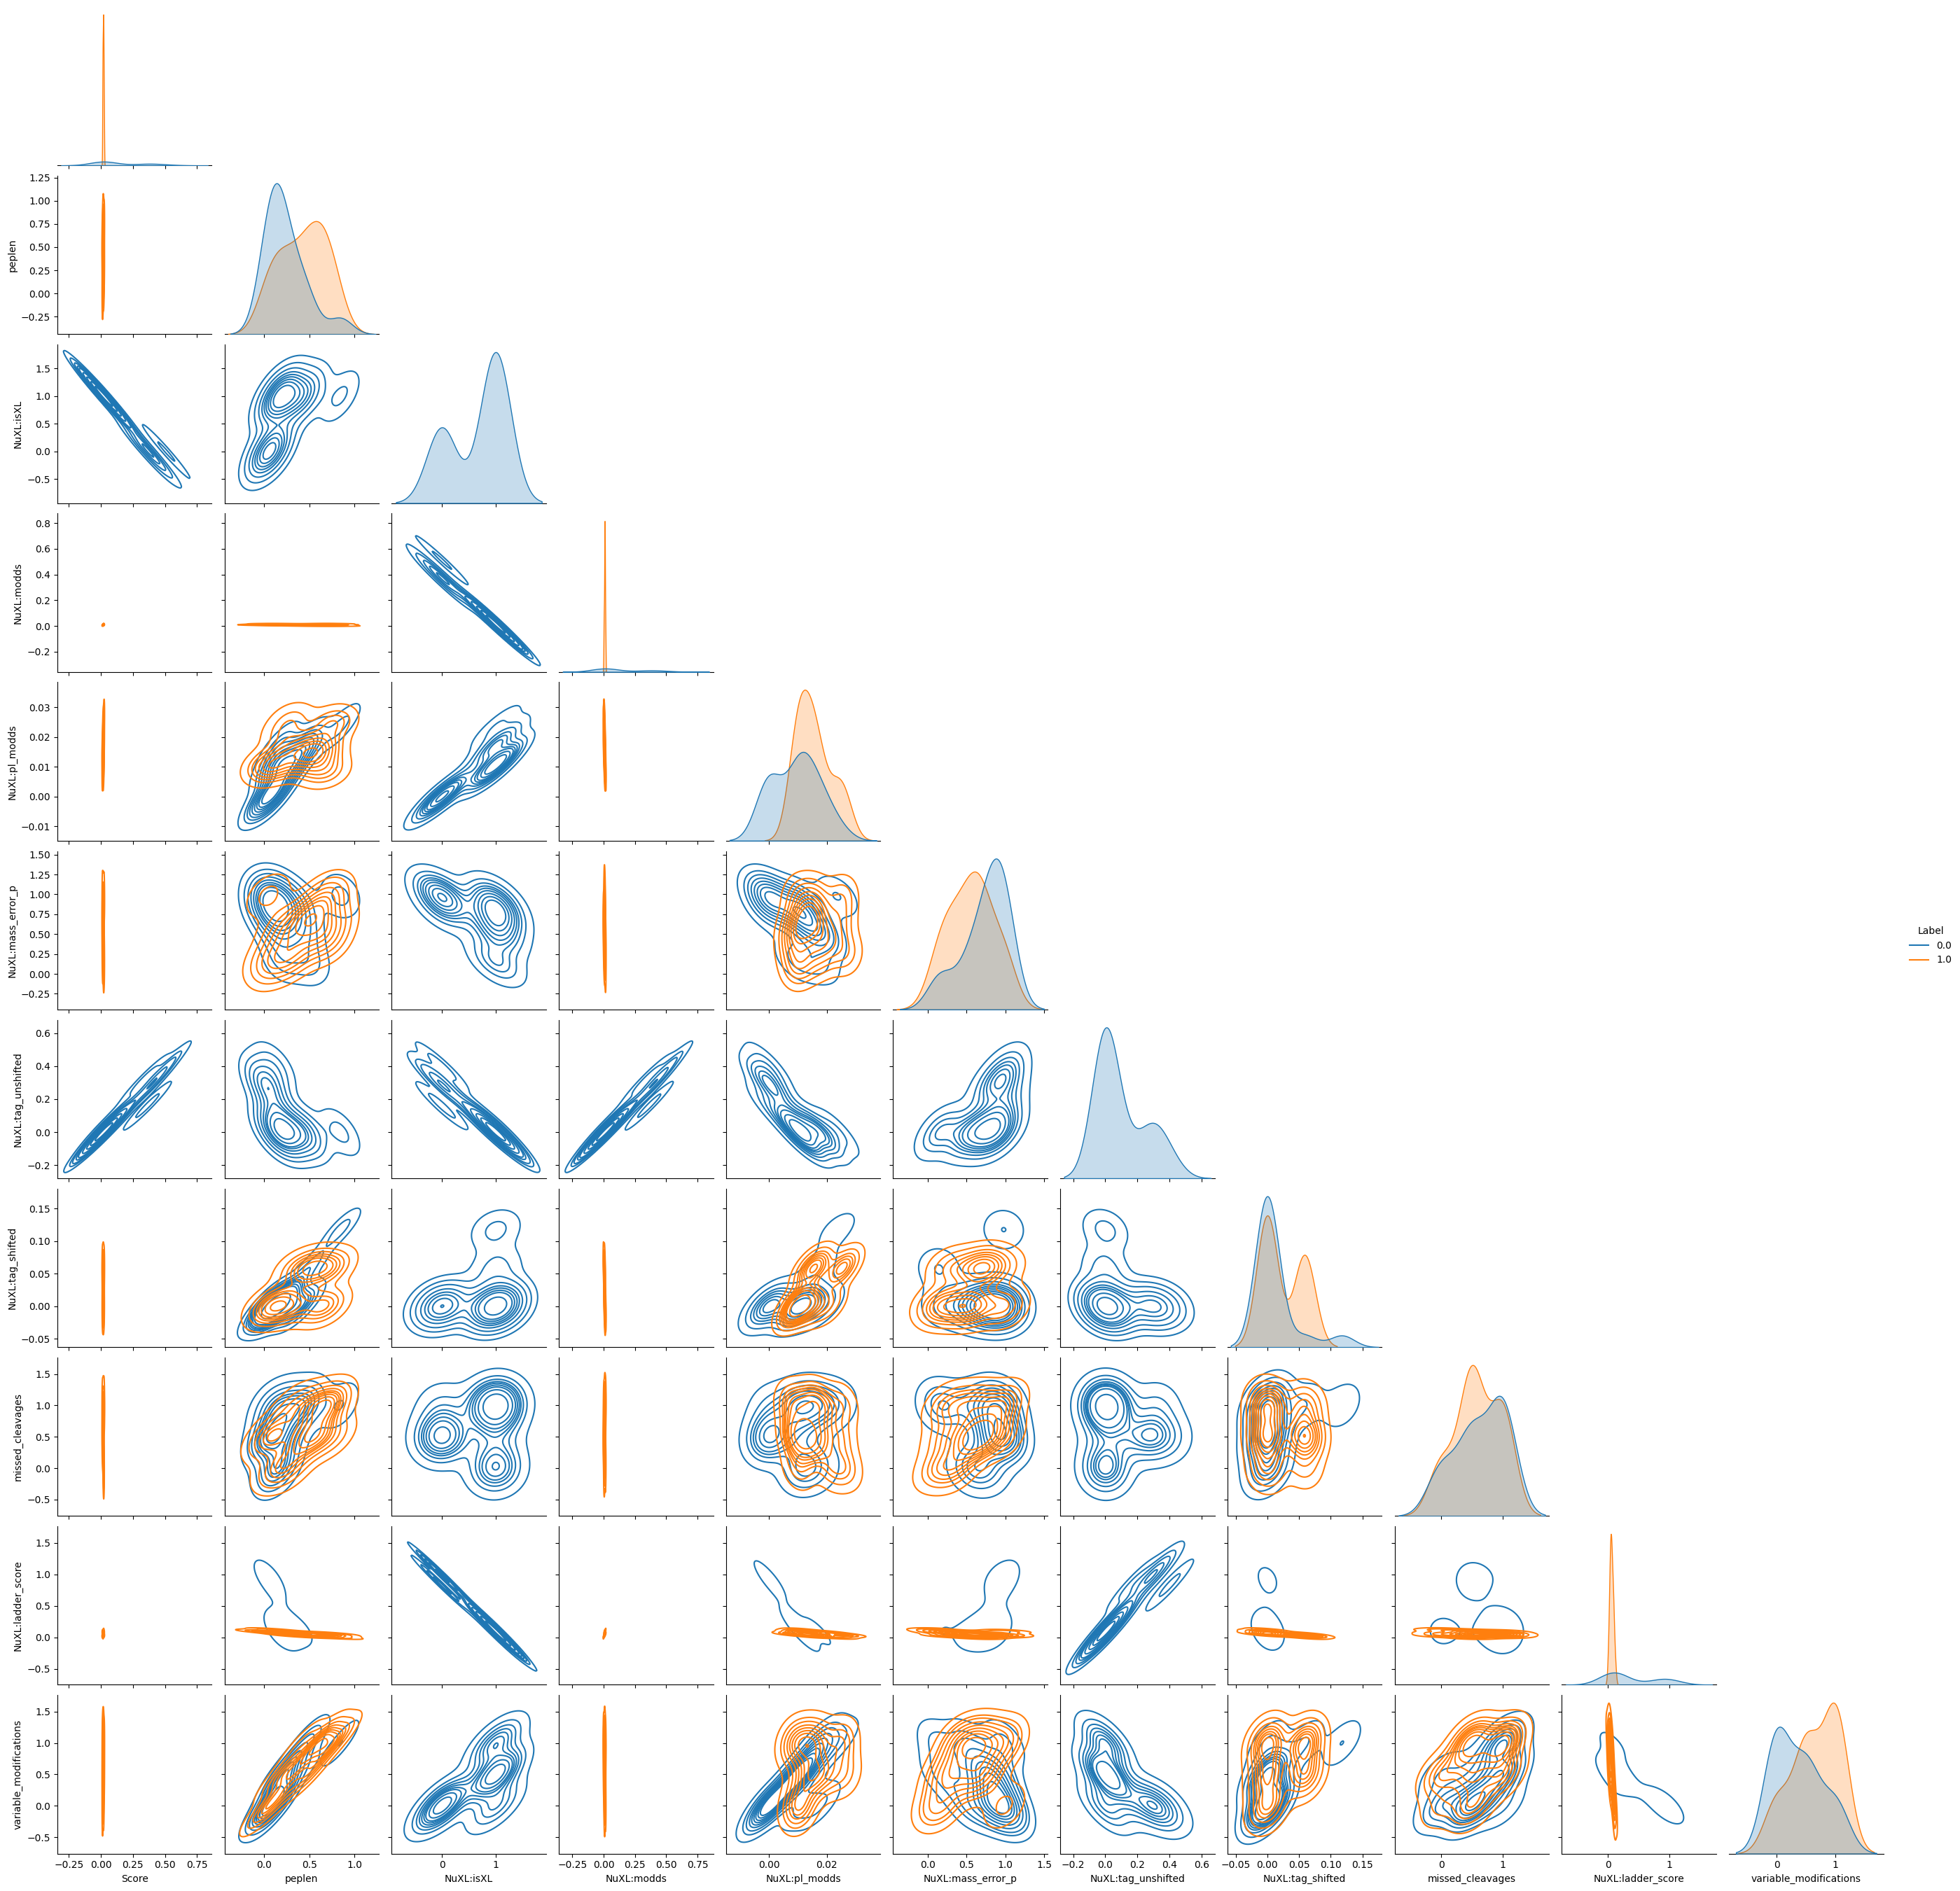

In [165]:
import seaborn as sns
sns.pairplot(df.loc[train_idx,features].join(pd.DataFrame(labels[train_idx], columns=['Label'])), hue='Label',kind="kde",   corner=True)